# Etape 7 — Machine Learning

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Préparation initiale

In [8]:
# Chargement du fichier de données consolidées
df = pd.read_csv('DataFrame_Complet.csv')

In [9]:
# On ne garde que les lignes avec un score CVSS et une sévérité, qui sont essentiels.
ml_df = df.dropna(subset=['CVSS_score', 'Base_severity']).copy()

In [10]:
# Remplissage des valeurs manquantes pour les scores EPSS avec 0
for col in ['EPSS_score', 'EPSS_percentile']:
    ml_df[col] = ml_df[col].fillna(0)

#### Correction ValueError: The least populated class in y has only 1 member, which is too few

In [13]:
ml_df = ml_df[ml_df['Base_severity'] != 'NONE'].copy()

## Apprentissage supervisé

In [14]:
print("\n--- Début de l'apprentissage supervisé ---")

le = LabelEncoder()
ml_df['Base_severity_encoded'] = le.fit_transform(ml_df['Base_severity'])


--- Début de l'apprentissage supervisé ---


In [15]:
X = ml_df[['CVSS_score', 'EPSS_score', 'EPSS_percentile']]
y = ml_df['Base_severity_encoded']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

Taille de l'ensemble d'entraînement : 2610
Taille de l'ensemble de test : 1119


In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

In [19]:
# Rapport de classification
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
target_names = le.inverse_transform(unique_labels)
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=target_names, labels=unique_labels))


Rapport de classification :
              precision    recall  f1-score   support

    CRITICAL       1.00      1.00      1.00       133
        HIGH       1.00      1.00      1.00       544
         LOW       0.89      0.94      0.91        17
      MEDIUM       1.00      1.00      1.00       425

    accuracy                           1.00      1119
   macro avg       0.97      0.98      0.98      1119
weighted avg       1.00      1.00      1.00      1119



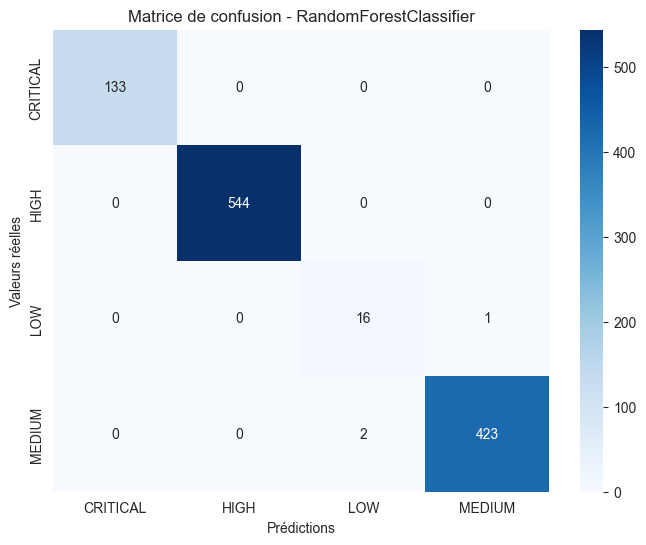

In [20]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de confusion - RandomForestClassifier')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()


## Apprentissage non supervisé

In [21]:
print("\n--- Début de l'apprentissage non supervisé ---")

features_for_clustering = ml_df[['CVSS_score', 'EPSS_score', 'EPSS_percentile']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)


--- Début de l'apprentissage non supervisé ---


In [22]:
# Application de K-Means pour trouver 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
ml_df['cluster'] = kmeans.fit_predict(X_scaled)

In [23]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=['CVSS_score', 'EPSS_score', 'EPSS_percentile'])
print("\nCaractéristiques moyennes des clusters :")
print(centers_df)


Caractéristiques moyennes des clusters :
   CVSS_score  EPSS_score  EPSS_percentile
0    5.466129    0.001080         0.199998
1    8.606117    0.872977         0.995071
2    8.255250    0.032596         0.455663


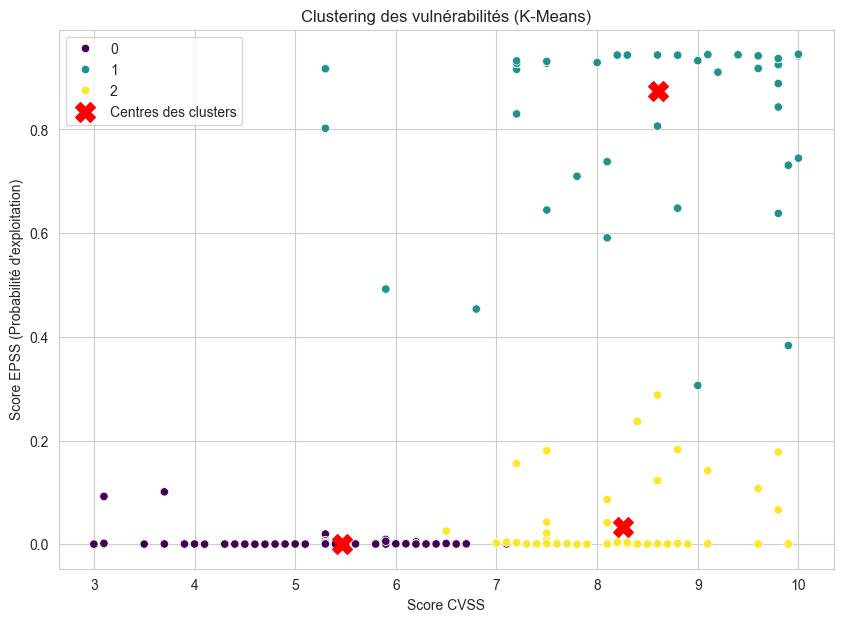

In [24]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=ml_df, x='CVSS_score', y='EPSS_score', hue='cluster', palette='viridis', legend='full')
plt.scatter(centers_df['CVSS_score'], centers_df['EPSS_score'], s=200, c='red', marker='X', label='Centres des clusters')
plt.title('Clustering des vulnérabilités (K-Means)')
plt.xlabel('Score CVSS')
plt.ylabel('Score EPSS (Probabilité d\'exploitation)')
plt.legend()
plt.grid(True)
plt.show()